In [38]:
import torch
import csv

import numpy as np
from matplotlib.colors import LinearSegmentedColormap

import torchvision
from torchvision import models

from captum.attr import IntegratedGradients
from captum.attr import NoiseTunnel
from captum.attr import visualization as viz
from captum.metrics import infidelity, sensitivity_max, infidelity_perturb_func_decorator

from helpers import get_labels, get_input_image, predict

default_cmap = LinearSegmentedColormap.from_list('custom blue', 
                                                 [(0, '#ffffff'),
                                                  (0.25, '#000000'),
                                                  (1, '#000000')], N=256)

## Initialize Resnet18

[Deep Residual Learning for Image Recognition](https://arxiv.org/abs/1512.03385)

In [2]:
model = models.resnet18(pretrained=True)
model = model.eval()

## Extract ImageNet class labels and get correct predicted label id for default image

In [3]:
labels_path, idx_to_labels = get_labels()
input, transformed_img = get_input_image()

In [4]:
predicted_label, pred_label_idx, prediction_score = predict(model, input, idx_to_labels)
print('Predicted:', predicted_label, '(', prediction_score.squeeze().item(), ')')

torch.Size([1, 3, 224, 224])
torch.Size([1, 1000])
Predicted: goose ( 0.4569336771965027 )


## Get Integrated Gradients attribution

[Axiomatic Attribution for Deep Networks, Mukund Sundararajan et al. 2017](https://arxiv.org/abs/1703.01365)

In [14]:
integrated_gradients = IntegratedGradients(model)
attributions_ig = integrated_gradients.attribute(input, target=pred_label_idx, n_steps=100)

## Generate explanation with NoiseTunnel

[Sanity Checks for Saliency Maps, Julius Adebayo et al. 2018](https://arxiv.org/abs/1810.03292)

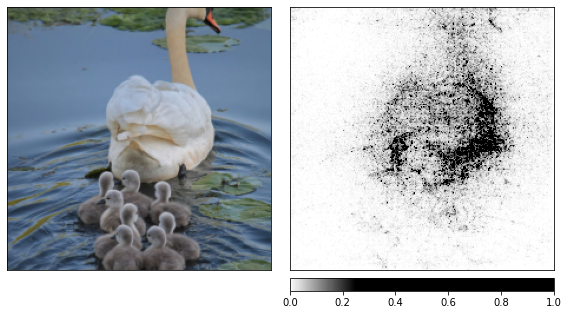

In [6]:
noise_tunnel = NoiseTunnel(integrated_gradients)

attributions_ig_nt = noise_tunnel.attribute(input, nt_samples=10, nt_type='smoothgrad_sq', target=pred_label_idx)
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_ig_nt.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      cmap=default_cmap,
                                      show_colorbar=True)

## Calculate Infidelity and Sensitivity metrics

[On the (In)fidelity and Sensitivity for Explanations](https://arxiv.org/abs/1901.09392)

In [7]:
# We need that for metric calculation
input.requires_grad = True

In [34]:
@infidelity_perturb_func_decorator(multipy_by_inputs=False)
def perturb_fn(inputs):
    noise = torch.tensor(np.random.normal(0, 0.003, inputs.shape)).float()
    return inputs - noise

infid = infidelity(model, perturb_fn, input, attributions_ig, target=pred_label_idx)

torch.Size([10])
torch.Size([10])
torch.Size([10])
1


In [36]:
sens = sensitivity_max(integrated_gradients.attribute, input, target=pred_label_idx, n_steps=10)

In [41]:
print(f"Infidelity: {infid.numpy()[0]}, Sensitivity: {sens.numpy()[0]}")

Infidelity: 0.0013776873353545977, Sensitivity: 0.49252035049773196


### Append results to results file

In [39]:
fields=['IG',infid.numpy()[0],sens.numpy()[0]]
with open('../data/results.csv','a') as fd:
    writer = csv.writer(fd)
    writer.writerow(fields)